<a href="https://colab.research.google.com/github/Wanita-8943/My_Main_Project_Lt-/blob/main/2.3_(1e_4)G4Lt_Train_Unfreeze_250.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#เรียกใช้ CSV

In [1]:
import pandas as pd
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv (r'/content/drive/MyDrive/All_File_Lt/Data/All_Data_Lt.csv')
df

,Fig_Age,Fig_Person,Class_Age+Gender,Class_Age,Class_0-18,Age(year),Class_0-1,Filename,Path_filename,Sex,Floder
0,1,1,Y07F,Y07,0,7,0,V1.jpg,/content/drive/My Drive/All_File_Lt/TVT_All_Lt...,Female,Both
1,2,1,Y07F,Y07,0,7,0,Flip_V1.jpg,/content/drive/My Drive/All_File_Lt/TVT_All_Lt...,Female,Both
2,3,2,Y07F,Y07,0,7,0,V2.jpg,/content/drive/My Drive/All_File_Lt/TVT_All_Lt...,Female,Both
3,4,2,Y07F,Y07,0,7,0,Flip_V2.jpg,/content/drive/My Drive/All_File_Lt/TVT_All_Lt...,Female,Both
4,5,3,Y07F,Y07,0,7,0,V3.jpg,/content/drive/My Drive/All_File_Lt/TVT_All_Lt...,Female,Both
...,...,...,...,...,...,...,...,...,...,...,...
4745,121,77,Y25M,Y25,18,25,1,Flip_J463.jpg,/content/drive/My Drive/All_File_Lt/TVT_All_Lt...,Male,Both
4746,122,78,Y25M,Y25,18,25,1,J464.jpg,/content/drive/My Drive/All_File_Lt/TVT_All_Lt...,Male,Both
4747,123,78,Y25M,Y25,18,25,1,Flip_J464.jpg,/content/drive/My Drive/All_File_Lt/TVT_All_Lt...,Male,Both
4748,124,79,Y25M,Y25,18,25,1,J465.jpg,/content/drive/My Drive/All_File_Lt/TVT_All_Lt...,Male,Both


#Imports

In [4]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

#กำหนดค่าพารามิเตอร์


In [5]:
batch_size = 16
width = 150
height = 150
epochs = 250
NUM_TRAIN = 2850
NUM_TEST = 950
dropout_rate = 0.2
input_shape = (height, width, 3)

#Clone efficientnet repo


In [6]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 1100, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 1100 (delta 133), reused 241 (delta 121), pack-reused 837
Receiving objects: 100% (1100/1100), 14.10 MiB | 16.65 MiB/s, done.
Resolving deltas: 100% (630/630), done.
/content/efficientnet_keras_transfer_learning


In [7]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [8]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

16717576/16717576 [==============================] - 3s 0us/step


#load model

In [9]:

import sys
sys.path.append('/content/drive/MyDrive/All_File_Lt/Model/Classification/Gender/2/(1e-4)G3_Freeze_250.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})
     

In [10]:
#load model 
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/All_File_Lt/Model/Classification/Gender/2/(1e-4)G3_Freeze_250.h5')
height = width = model.input_shape[1]

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 2,562
Non-trainable params: 4,049,564
_________________________________________________________________


In [12]:
# multiply_16
# set 'multiply_16' and following layers trainable
model.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False  

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


#สร้างโฟลเดอร์ Train Valodation และ Test

In [14]:
train = df[df['Fig_Age'].between(1,75)]
val = df[df['Fig_Age'].between(76,100)]

In [15]:

DATA_PATH = "/content/drive/My Drive/All_File_Lt/TVT_All_Lt"
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'train')
print(train_dir)
validation_dir = os.path.join(DATA_PATH, 'validation')
print(validation_dir)

/content/drive/My Drive/All_File_Lt/TVT_All_Lt/train
/content/drive/My Drive/All_File_Lt/TVT_All_Lt/validation



#Train

In [16]:

# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = train_dir,
        x_col = 'Path_filename',
        y_col = 'Sex',
        class_mode = 'categorical',
        target_size=(height, width),
        batch_size=batch_size)

validation_generator = test_datagen.flow_from_dataframe(
        dataframe = val,
        directory = validation_dir,
        x_col = 'Path_filename',
        y_col = 'Sex',
        class_mode = 'categorical',
        target_size=(height, width),
        batch_size=batch_size)

Found 2850 validated image filenames belonging to 2 classes.
Found 950 validated image filenames belonging to 2 classes.


In [17]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-17-caa7b37242a8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/250
178/178 [==============================] - 792s 4s/step - loss: 0.6064 - acc: 0.6725 - val_loss: 0.5956 - val_acc: 0.7013
Epoch 2/250
178/178 [==============================] - 23s 129ms/step - loss: 0.6073 - acc: 0.6680 - val_loss: 0.6093 - val_acc: 0.6907
Epoch 3/250
178/178 [==============================] - 24s 133ms/step - loss: 0.5868 - acc: 0.6856 - val_loss: 0.6179 - val_acc: 0.6727
Epoch 4/250
178/178 [==============================] - 23s 128ms/step - loss: 0.6149 - acc: 0.6725 - val_loss: 0.6281 - val_acc: 0.6621
Epoch 5/250
178/178 [==============================] - 23s 129ms/step - loss: 0.5936 - acc: 0.6874 - val_loss: 0.5880 - val_acc: 0.7087
Epoch 6/250
178/178 [==============================] - 24s 130ms/step - loss: 0.6172 - acc: 0.6683 - val_loss: 0.6102 - val_acc: 0.6854
Epoch 7/250
178/178 [==============================] - 24s 133ms/step - loss: 0.6037 - acc: 0.6807 - val_loss: 0.5993 - val_acc: 0.6896
Epoch 8/250
178/178 [=============================

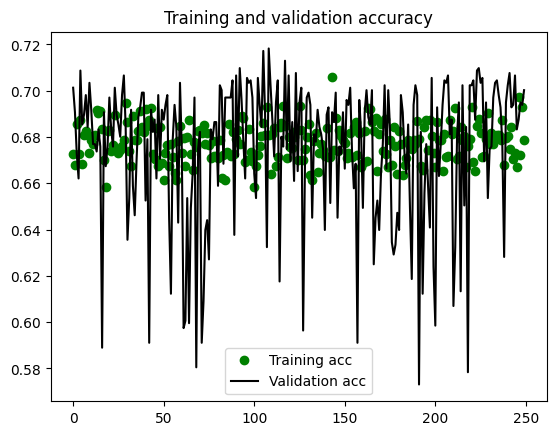

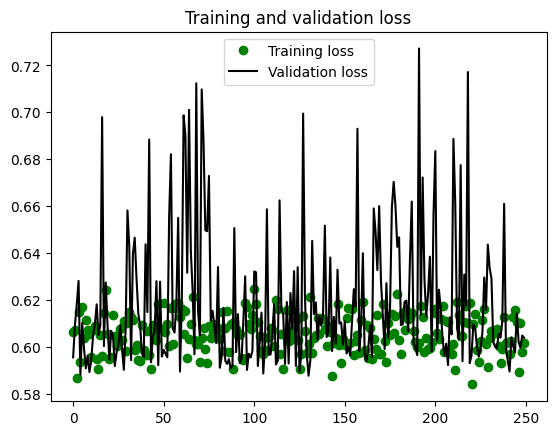

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'go', label='Training acc')
plt.plot(epochs_x, val_acc, 'k', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'go', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Download the model


In [19]:
os.makedirs('/content/drive/My Drive/All_File_Lt/Model/Classification/Gender/', exist_ok=True)
model.save('/content/drive/MyDrive/All_File_Lt/Model/Classification/Gender/2.3_(1e-4)G4_Unfreeze_250.h5')

In [20]:
# from google.colab import files
# files.download('/content/drive/MyDrive/All_File_Lt/Model/G1_Freeze_250.h5')